In [1]:
import xarray as xr
import climtas.io
import dask
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory("dask-worker-space")
dask.distributed.Client(local_directory=tempdir.name, memory_limit='16gb')

Client Scheduler: tcp://127.0.0.1:44967 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 44.92 GiB


In [3]:
temp_data_dt = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TNn_detrended.nc', chunks={'member':1, 'time':-1, 'lat':110, 'lon':110}).sel(time=slice('1901-11', '2015-10'))

In [4]:
temp_data_dt

,Array,Chunk
Bytes,52.84 GiB,126.29 MiB
Shape,"(80, 1368, 180, 360)","(1, 1368, 110, 110)"
Count,1281 Tasks,640 Chunks
Type,float64,numpy.ndarray


### Open HadISST dataset

In [5]:
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [6]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [7]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-11', '2015-10'))/sst_std

In [8]:
# Take the mean over every quarter
quarterly_nino = nino34_index.resample(time='QS-NOV').mean('time')

# Select out NDJ nino34 index
nino_ndj = quarterly_nino.isel(time=slice(0,None,4))

In [9]:
def ensemble_correlation(data, nino):
    
    # Take min over every quarter 
    quarterly_data = data.resample(time='QS-NOV').min('time')

    # Calculate instantaneous regression 
    quarterly_correlation = func.correlate_nino_by_month(quarterly_data, nino)
    
    return quarterly_correlation

In [10]:
%%time 
correlation_list = []
for m in temp_data_dt.member:
    correlation_list.append(ensemble_correlation(temp_data_dt.sel(member=m), nino_ndj))

CPU times: user 2h 53min 36s, sys: 20min 49s, total: 3h 14min 25s
Wall time: 3h 25min 7s


In [11]:
correlations = xr.concat(correlation_list, dim='member')

In [12]:
correlations

<xarray.DataArray (member: 80, month: 4, lat: 180, lon: 360)>
array([[[[ 1.19361348e-01,  1.18498325e-01,  1.17315688e-01, ...,
           1.22208987e-01,  1.21895805e-01,  1.20114196e-01],
         [ 1.53936336e-01,  1.50141867e-01,  1.47430721e-01, ...,
           1.55899826e-01,  1.55704498e-01,  1.55802402e-01],
         [ 6.87560608e-02,  6.94503572e-02,  6.94264290e-02, ...,
           8.95560279e-02,  8.20515959e-02,  7.53979509e-02],
         ...,
         [-4.87013664e-04, -2.22594139e-03, -1.57507274e-03, ...,
          -2.52646581e-04, -5.58257304e-04, -8.71382638e-04],
         [-3.06252443e-02, -2.99175925e-02, -2.95070920e-02, ...,
          -2.93414271e-02, -2.91819628e-02, -3.07101084e-02],
         [-7.23772021e-02, -7.26244391e-02, -7.17540281e-02, ...,
          -7.34731687e-02, -7.24017039e-02, -7.11659239e-02]],

        [[-1.22956865e-02, -1.17128187e-02, -1.13592599e-02, ...,
          -1.01032712e-02, -1.09117716e-02, -1.07829748e-02],
         [-1.18797978e-01, -1.13636260e-01, -1.07311000e-01, ...,
          -1.14044226e-01, -1.15514915e-01, -1.15999131e-01],
         [-9.96781465e-02, -9.18728430e-02, -8.33971458e-02, ...,
          -1.11577641e-01, -1.00845506e-01, -9.73094291e-02],
...
         [-3.87851837e-02, -3.87864929e-02, -3.97556471e-02, ...,
          -3.63854715e-02, -3.64445655e-02, -3.74011684e-02],
         [-2.16094150e-02, -2.49522905e-02, -2.61941856e-02, ...,
          -1.97639888e-02, -1.99071661e-02, -1.95970066e-02],
         [-3.54943622e-02, -3.56759784e-02, -3.65197558e-02, ...,
          -3.71910578e-02, -3.55865600e-02, -3.49949142e-02]],

        [[ 9.00775091e-02,  9.04957671e-02,  8.95022549e-02, ...,
           9.07220925e-02,  9.06607115e-02,  8.89282720e-02],
         [ 7.79459498e-02,  7.71031854e-02,  7.43455068e-02, ...,
           8.66240493e-02,  8.17812326e-02,  8.06466007e-02],
         [ 5.12468818e-02,  5.22554397e-02,  5.13141769e-02, ...,
           5.59844193e-02,  5.43037680e-02,  5.34583605e-02],
         ...,
         [-7.59575486e-03, -8.39263013e-03, -8.80236215e-03, ...,
          -6.49299728e-04, -3.42653223e-03, -5.87832400e-03],
         [-2.65501892e-02, -2.87800439e-02, -3.15248438e-02, ...,
          -1.25686818e-02, -1.66639345e-02, -2.21974843e-02],
         [ 1.41267597e-02,  1.42084980e-02,  1.46701846e-02, ...,
           1.57069441e-02,  1.42459236e-02,  1.42073934e-02]]]])
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 72 73 74 75 76 77 78 79 80
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int64 2 5 8 11

In [13]:
# Save as netcdf
correlations.to_netcdf('/g/data/w40/rl5183/20CR/temp/TNn_correlations_all_members_1901_2015.nc')

In [2]:
correlations = xr.open_dataarray('/g/data/w40/rl5183/20CR/temp/TNn_correlations_all_members_1901_2015.nc')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/local/eg3/rl5183/tmp/ipykernel_2449570/743181364.py:21: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('ensemble_mean_corr_tnn.jpg', bbox_inches='tight', dpi=300, quali

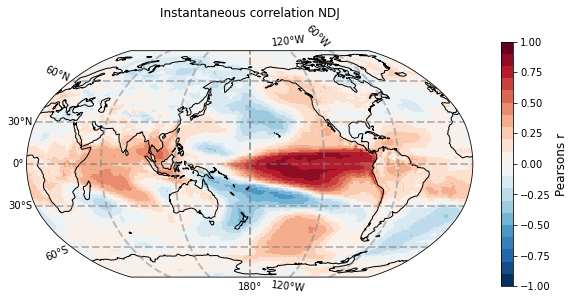

In [3]:
# Plot ensemble mean to check 
fig = plt.figure(figsize=(10,5))

vmin=-1
vmax=1

ax = fig.add_subplot(111, projection=ccrs.Robinson(180))
C = correlations.sel(month=11).mean(dim='member').plot(ax=ax, vmin=vmin, vmax=vmax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('RdBu_r', 20))
ax.coastlines()
ax.set_global()
ax.set_title('Instantaneous correlation NDJ')
# Gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
# Colorbar
cbar = plt.colorbar(C, ax=ax, shrink=0.9, pad=0.05)
cbar.ax.set_ylabel('Pearsons r', fontsize=12)

# plt.savefig('ensemble_mean_corr_tnn.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

In [16]:
# Calculate standrd deviation between ensemble members
ensemble_std_corr = np.apply_along_axis(np.std, 0, correlations)

In [17]:
# Covert to xarray
ensemble_std_corr = xr.DataArray(ensemble_std_corr, coords=correlations.mean(dim='member').coords)
# Save as netcdf 
ensemble_std_corr.to_netcdf('/g/data/w40/rl5183/20CR/temp/TNn_ensemble_std_corr_1901_2015.nc')